# STAT 548/CSE 547 Tutorial: Parallel Processing

### **Instructor**:</b> Marina Meila
### **TA**: Medha Agarwal
### **Date**: May 09, 2025

---

## ⏰ Previously...

We looked at vectorization - both as a process of converting scalar operations (loop-based) into array operations and as a method for converting input data from its raw format (i.e. text ) into vectors of real numbers.

---

## 📘 Tutorial Overview

In this tutorial, we will look at methods for paralell processing using multiple cores of CPU and GPUs. We iwll look at applications like vectorization, embarassingly parallel loops, or ML model training that benefit from parallel processing.

## 1 Compute Environments


### 1.1. Basic Hardware

*Source:* [NVIDIA](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) and [TDS](https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d)

- Processors are electronic circuitry that execute computer instructions, whose minimal unit is a **transistor**. 
- The two standard processors on most systems are called the **Central Processing Unit (CPU)** and the **Graphic Processing Unit (GPU)**.
- These processors differ in their allotment of transistors to computing processes. 
    - CPUs dedicate these transistors into a small number of **logical cores**, with a stronger emphasis on circuitry used for **caches** (data storage that speeds up access) and **control flow** (`if-else` statements, `for` and `while` loops, etc). 
    - GPUs, on the other hand, can have thousands of cores, each capable only of simple arithmetic operations.
- Thus, for highly parallelizable operations (those that can be split into independent **threads**), such as matrix multiplications common in ML/DL, GPUs have become an essential part of any computing infrastructure.
- That being said, parallelizing more complex operations, such as hyperparameter search, is still done on machines with a large number of CPU cores. Examples include **CPU Clusters** such as the Stat cluster, which uses a manager called Slurm to schedule computation.
- **Tensor Processing Units (TPUs)** are processors that are built specifically for the tensor operations in neural networks training. Specifically, it was made to speed up the operations of TensorFlow, which used to be the dominant DL framework.

Use `htop` in a terminal in order to "see" the physical CPU cores at work. When running operations that make use of all of the cores (such as a large matrix multiplications), you should see the bars light up. 

In [65]:
import numpy as np

np.random.seed(123)

n_sim = 10000
n = 10000

try:
    for i in range(10000):
        A = np.random.normal(size=(n, n))
        B = np.random.normal(size=(n, n))

        C = A @ B
except KeyboardInterrupt:
    print("Graceful Exit")

Graceful Exit


When working on a server, use `tmux` to let processes run in the background while you can break the connection. This is not only a convenient method, but very safe as well. A few relevant commands:
- `tmux`: Create a session.
- `ctrl + B`, then `%`: Create a panel within a session.
- `ctrl + B`, then `D`: Detach from a session.
- `tmux ls`: List the current sessions.
- `tmux attach -t <session_name>`: Attach to a running session.

## 2. Parallelism over CPU and GPU

Parallel programming is a method of speeding up computations by dividing tasks across multiple processing units that execute simultaneously. In machine learning, this is essential for handling large datasets and complex models efficiently. 

- CPU design philosophy: optimized for sequential processing

  - Fewer, more powerful cores with complex control units
  - Large caches and branch prediction
  - Optimized for irregular memory access and control flow
  - Parallelism achieved through multithreading or multiprocessing - where a few powerful cores execute different parts of a task concurrently—useful for data loading or feature processing.

- GPU design philosophy: optimized for parallel processing
  - Thousands of simpler cores
  - Specialized for floating-point operations
  - SIMT (Single Instruction, Multiple Thread) execution model
  - Memory architecture optimized for throughput
  - well-suited for operations like matrix multiplication and deep learning training


## 3. Application 1: Vectorized Implementation

**Implicit Parallelism**

- Because matrix operations are the prototypical use case of parallelism, many computing processes can benefit from parallelization implicitly by being represented in linear algebraic form.
- Such implementations are said to be **vectorized**. The main idea is to avoid all `for` loops where possible, and use libraries like `numpy` and `pytorch` for matrix and tensor algebra.
- To develop software/algorithms in any kind of large-scale or production setting, it is very important to make vectorization a constant habit. A core part of why GPUs (and even CPUs) make processes faster is by distributing the load across all of the logical cores. Using `for` loops ruins this benefit and wastes valuable compute time.
- Another separate but related issue is list concatenation; if you are trying to apply a function to a sequence of outputs, it is sometimes tempting to have a "running" list for which you concatenate the new value through the iteration of a `for` loop. In these sitatuations, it is always better to **pre-allocate** arrays, or be confident that you are **appending** (in $O(1)$) instead of copying the entire contents of the array every time.

#### Example: Nadaraya-Watson with Gaussian Kernel

In this example, we implement multiple versions of the Nadaraya-Watson regression estimator. Specifically, consider a supervised learning problem in which we are given an $n$-sized training set $(x_1, y_1), ..., (x_n, y_n)$ of feature vectors $x_i \in \mathbb{R}^d$ and label $y_i \in \mathbb{R}$. Given a test point $x \in \mathbb{R}^d$, the predicted value of the label $\hat{y}$ is given by
\begin{equation}
    \hat{y} = \sum_{i=1}^n \frac{y_i k\left(\frac{x - x_i}{h}\right)}{\sum_{j=1}^n k\left(\frac{x - x_j}{h}\right)},
\end{equation}
where
\begin{align*}
    k(z) = e^{-\frac{1}{2}||z||^2}
\end{align*}
is the Gaussian kernel and and $h > 0$ is a bandwidth parameter. Kernel methods offer plenty of opportunities to replace wasteful `for` loops with efficient vectorized implementations, especially when $n$ and $d$ are very large.

In [66]:
import time

from sklearn.utils.validation import check_X_y, check_array
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import numpy as np

In [67]:
def naive_gaussian_kernel(x1, x2, h):
    sq_norm = 0
    for j in range(len(x1)):
        sq_norm += (x1[j] - x2[j]) ** 2
    return np.exp(-0.5 * sq_norm / h ** 2)

class NaiveNadarayaWatsonRegressor:
    def __init__(self, bandwidth, kernel=naive_gaussian_kernel):
        self.h = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.X_train = X
        self.y_train = y
        
        return self
    
    def predict(self, X):
        X = check_array(X)
        
        y_pred = []
        for x in X:
            num = 0
            denom = 0
            for i, x_i in enumerate(self.X_train):
                num += self.y_train[i] * self.kernel(x, x_i, self.h)
                denom += self.kernel(x, x_i, self.h)
            y_pred.append(num / denom)
            
        return np.array(y_pred).reshape(-1)

**Exercise 1:** Why does the `fit` method above simply store the training data? 

**Exercise 2:** What are other algorithms that might be implemented in this way? (These are referred to as **lazy learners**.

**Exercise 3:** Based on our discussion of nearest neighbors in high dimensions, what kinds of operations could occur in the `fit` method for approximate lazy learners?

In [68]:
def generate_data(n, d):
    X = np.random.normal(size=(n, d))
    coef = np.random.normal(size=(d,))
    intercept = np.random.normal()
    noise = np.random.normal(size=(n,))
    y = (X @ coef + intercept + noise).reshape(-1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, y_train, X_test, y_test

Using a test set $(x_1, y_1), ..., (x_n, y_n)$, we measure performance using the $R^2$ score (also known as explained variance).
\begin{equation}
    R^2 = \frac{\sum_{i=1}^n (\hat{y}_i - y_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2},
\end{equation}
where
\begin{equation}
    \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i
\end{equation}
is the sample mean.

In [69]:
# DEMO: 
np.random.seed(123)

n = 10000
d = 10

X_train, y_train, X_test, y_test = generate_data(n, d)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 10)
(8000,)
(2000, 10)
(2000,)


In [70]:
try:
    start = time.time()
    naive_model = NaiveNadarayaWatsonRegressor(bandwidth=0.5).fit(X_train, y_train)
    y_pred = naive_model.predict(X_test)
    print("R^2: ", r2_score(y_test, y_pred))
    end = time.time()
    print("Time: %0.4f seconds." % (end - start))
except KeyboardInterrupt:
    print("Too slow! :'(")

Too slow! :'(


Give evalutation set $z_1, ..., z_m$, let $K \in \mathbb{R}^{m \times n}$ be the matrix such that 
\begin{align*}
    K_{ij} = k\left(\frac{z_i - x_j}{h}\right).
\end{align*}
Then, let $y = (y_1, ..., y_n)^\top \in \mathbb{R}^n$ and $\hat{y} = (\hat{y}_1, ..., \hat{y}_m)^\top \in \mathbb{R}^m$. It holds that 
\begin{align*}
\hat{y} = \frac{Ky}{K 1_n},
\end{align*}
where the division is element-wise. This will lead to a vectorized implementation. For now, we use the `sklearn` function for `pairwise_distances`, but we will soon see how to make a vectorized implementation of this as well.

In [71]:
class VectorizedNadarayaWatsonRegressor:
    def __init__(self, bandwidth):
        self.h = bandwidth
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.X_train = X
        self.y_train = y
        
        return self
    
    def predict(self, X):
        X = check_array(X)
        
        # n_eval by n_train kernel matrix.
        kernels = np.exp(-0.5 * pairwise_distances(X, self.X_train) ** 2 / self.h ** 2)
        
        # Element-wise division
        return (kernels @ self.y_train) / kernels.sum(axis=1)

**Exercise 4:** How can we use matrix operations to implement a vectorized version of pairwise Euclidean distances? That is, given the matrix $X \in \mathbb{R}^{n_1 \times d}$, and the matrix $Z \in \mathbb{R}^{n_1 \times d}$, how can we produce the matrix $D \in \mathbb{R}^{n_1 \times n_2}$, where
\begin{align*}
    D_{ij} = ||x_i - z_j||_2 ?
\end{align*}

**Solution:** Represent the Euclidean distance as a scalar product.
\begin{align*}
    D_{ij} = ||x_i - z_j||_2 = \sqrt{(x_i - z_j)^\top (x_i - z_j)} = \sqrt{x_i^\top x_i + z_j^\top z_j - 2 x_i^\top z_j}.
\end{align*}
The $x_i^\top x_i$ and $z_j^\top z_j$ terms can be computed by taking the norms of the rows of $X$ and $Z$. The cross term $x_i^\top z_j$ can be computed via the matrix multiplication $X^\top Z$. Do we need to compute $X^\top X$ or $Z^\top Z$?

In [72]:
try:
    start = time.time()
    vectorized_model = VectorizedNadarayaWatsonRegressor(bandwidth=0.5).fit(X_train, y_train)
    y_pred = vectorized_model.predict(X_test)
    print("R^2: ", r2_score(y_test, y_pred))
    end = time.time()
    print("Time: %0.4f seconds." % (end - start))
except KeyboardInterrupt:
    print("Too slow! :'(")

R^2:  0.7880181382483236
Time: 0.3733 seconds.


#### Extending to the GPU

- These kinds of operations can be made even faster by using a GPU. In order to interact with it, we use the `torch` package (PyTorch).
- Using PyTorch is largely the same as `numpy`. The main difference is that the quintessential array object becomes a `torch.tensor` instead of a `numpy.ndarray`. Second, tensors exist on a "device" which can either be `"cpu"` for the CPU, or `"cuda"` for the GPU.

In [73]:
import torch

def set_device():
    # If there's a GPU available...
    if torch.cuda.is_available():

        # Tell PyTorch to use the GPU.
        device = torch.device("cuda")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))

    # If not...
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    return device

def pdist(sample_1, sample_2, eps=1e-5):
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
    norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
    norms = (norms_1.expand(n_1, n_2) +
             norms_2.transpose(0, 1).expand(n_1, n_2))
    distances_squared = norms - 2 * sample_1.mm(sample_2.t())
    return torch.sqrt(eps + torch.abs(distances_squared))

class GPUNadarayaWatsonRegressor:
    def __init__(self, bandwidth):
        self.h = bandwidth
        self.device = set_device()
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        self.X_train = torch.from_numpy(X).to(self.device)
        self.y_train = torch.from_numpy(y).to(self.device)
        
        return self
    
    def predict(self, X):
        X = check_array(X)
        X = torch.from_numpy(X).to(self.device)
        
        # n_eval by n_train kernel matrix.
        kernels = torch.exp(-0.5 * pdist(X, self.X_train) ** 2 / self.h ** 2)
        
        # Element-wise division
        return (torch.matmul(kernels, self.y_train) / kernels.sum(axis=1)).to("cpu")

In [74]:
# DEMO: Run in Colab environment.
try:
    start = time.time()
    gpu_model = GPUNadarayaWatsonRegressor(bandwidth=0.5).fit(X_train, y_train)
    y_pred = gpu_model.predict(X_test)
    print("R^2: ", r2_score(y_test, y_pred))
    end = time.time()
    print("Time: %0.4f seconds." % (end - start))
except KeyboardInterrupt:
    print("Too slow! :'(")

There are 4 GPU(s) available.
We will use the GPU: NVIDIA TITAN Xp
R^2:  0.7880181382483237
Time: 0.0287 seconds.


## 4. Application 2: Embarassingly Parallel Loops

**Definition**

- In the previous section we were using a combination of linear algebra representations and built-in functions to benefit from parallelization. This method only works for inherently mathematical objects, which is also the reason we got a speed up from the GPU.
- When we would like to parallelize more complicated programming logic, we have to use explicit parallelization. This means we describe explicitly a "batch" operation which should be split among various threads.
- A special (but very common) case of this situation is **embarrassingly parallel loops**. This occurs when there is a `for` loop for which the result of computation in each iteration has no relationship to the result of computation in other iterations. 
- In these cases, the code essentially "looks" like a `for` loop. We just have to instruct the machine to split this load over a certain number of cores.
- One thing to note that explicit parallelism often has an overhead cost, so sometimes for small scale problems it can even be slower than just iterating sequentially. Doing this correctly requires some knowledge of the hardware system its running on.

**Exercise 4.1:** Please name some iterated computations in machine learning settings that are and are not embarrassingly parallelizable. 

**Exercise 4.2:** Based on their description, are embarrassingly parallel workloads better distributed over CPU cores or GPU cores? Why?

 **Exercise 4.1**

*Embarrassingly parallelizable computations:*

* **Inference on independent samples**: Making predictions on multiple test inputs where each input can be evaluated separately.
* **Hyperparameter tuning** (e.g., grid search or random search): Each model configuration can be trained independently.
* **Cross-validation folds**: Training models on different folds does not depend on the others.
* **Data augmentation (offline)**: Applying random transformations to different images or sequences independently.

*Not embarrassingly parallelizable computations:*

* **Gradient descent with shared parameters**: Each iteration depends on the model state updated in previous steps.
* **Sequential RNN training**: Later steps depend on hidden states from earlier ones.
* **Backpropagation through time (BPTT)** in recurrent models: Requires passing gradients backward through dependent steps.
* **Batch normalization during training**: Requires computing statistics (mean/variance) over the entire batch, introducing dependencies.

**Exercise 4.2**

*Embarrassingly parallel workloads are often better distributed over GPU cores**—**but it depends on the nature of the task*.

* **GPUs** are ideal when the computation per task is numeric-heavy, uniform, and can be written in a vectorized or SIMD fashion. They offer massive throughput for simple operations on large datasets (e.g., image processing, vector math, matrix ops).
* **CPUs** are often better when each task involves complex logic, branching, or irregular memory access, which GPUs handle less efficiently.


When it comes to implementation, typical options in Python are `joblib` and `multiprocessing` for parallel CPU processing and PyTorch with CUDA for GPU-based inference and augmentation. In R, the `apply` family is a common option. 

In [75]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed
import time

### 4.1 Inference on independent samples

For CPU parallelism (e.g., with scikit-learn):

In [ ]:
# Load MNIST (~70,000 samples, 784 features)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Reduce size for faster training, but keep test large for benchmarking
X_train, X_test, y_train, y_test = train_test_split(X[:20000], y[:20000], test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)
model.fit(X_train, y_train)

In [78]:
start_serial = time.time()

y_pred_serial = [model.predict(x.reshape(1, -1))[0] for x in X_test]

end_serial = time.time()
print(f"Serial inference time: {end_serial - start_serial:.4f} seconds")

def predict_one(x):
    return model.predict(x.reshape(1, -1))[0]

start_parallel = time.time()

y_pred_parallel = Parallel(n_jobs=-1)(delayed(predict_one)(x) for x in X_test)

end_parallel = time.time()
print(f"CPU Parallel inference time: {end_parallel - start_parallel:.4f} seconds")


Serial inference time: 1.1348 seconds
CPU Parallel inference time: 0.6426 seconds


If using a GPU-compatible model (e.g., PyTorch), batch inference uses GPU cores naturally:

In [79]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [81]:
# Load MNIST and move to GPU
transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
print(test_dataset.data.shape)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Simple model
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        return self.fc(x)

# Initialize and move model to GPU
device = set_device()
model = SimpleNN().to(device)

# Dummy training step (skipped here) – just use random weights
model.eval()

# Inference on GPU
start_gpu = time.time()
all_preds = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())

end_gpu = time.time()
print(f"GPU inference time: {end_gpu - start_gpu:.4f} seconds")


torch.Size([10000, 28, 28])
There are 4 GPU(s) available.
We will use the GPU: NVIDIA TITAN Xp
GPU inference time: 1.1141 seconds


### 4.2 Hyperparameter tuning

We use `joblib` to search for the best bandwidth for the Nadaraya-Watson estimator. As before, use `htop` to ensure that your code is working properly. 

In [82]:
bandwidths = np.logspace(-1, 3, 30)
n = 10000
d = 10

X_train, y_train, X_test, y_test = generate_data(n, d)

In [29]:
is_parallel = True

# Define function that performs each iteration.
def worker(bandwidth):
    model = VectorizedNadarayaWatsonRegressor(bandwidth=bandwidth).fit(X_train, y_train)
    return r2_score(y_test, model.predict(X_test))

def search(is_parallel):
    try:
        if is_parallel:
            # Use n_jobs to determine how many cores will be used. Negative values imply "all but".
            r2 = Parallel(n_jobs=-2)(delayed(worker)(bandwidth) for bandwidth in bandwidths)
        else:
            r2 = []
            for bandwidth in bandwidths:
                r2.append(worker(bandwidth))
    except KeyboardInterrupt:
        print("Too slow! :'('")

    return r2
    
start = time.time()
r2 = search(False)
print(f"Sequential hyperparameter search takes {time.time() - start:.2f} seconds.")

start = time.time()
r2 = search(True)
print(f"Parallelized hyperparameter search takes {time.time() - start:.2f} seconds.")

Sequential hyperparameter search takes 8.27 seconds.
Parallelized hyperparameter search takes 2.44 seconds.


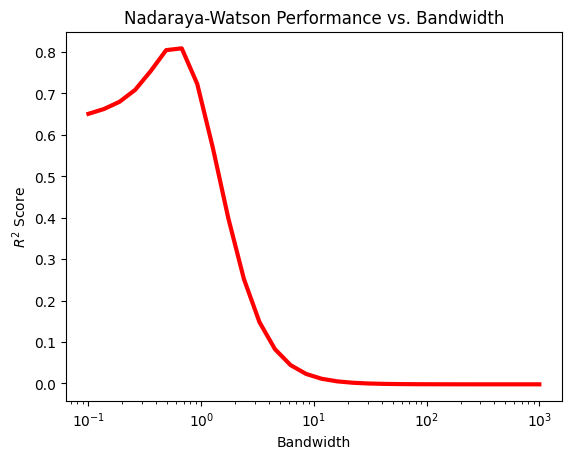

In [31]:
import matplotlib.pyplot as plt

plt.plot(bandwidths, r2, linewidth=3, color="red")
plt.xscale('log')
plt.xlabel("Bandwidth")
plt.ylabel(r"$R^2$ Score")
plt.title("Nadaraya-Watson Performance vs. Bandwidth")
plt.show()

### 4.3 Cross-validation folds

In [34]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

# ------------------------
# Load and prepare dataset
# ------------------------
print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data[:2000], mnist.target[:2000].astype(int)  # Subset for speed

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------
# Serial Cross-Validation
# ------------------------
print("\nRunning serial cross-validation...")
start_serial = time.time()
serial_accuracies = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LogisticRegression(max_iter=1000, solver='lbfgs')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    serial_accuracies.append(acc)

end_serial = time.time()
print(f"Serial CV Accuracy: {np.mean(serial_accuracies):.4f}")
print(f"Serial Time: {end_serial - start_serial:.2f} seconds")

# ------------------------
# Parallel Cross-Validation
# ------------------------
print("\nRunning parallel cross-validation...")

def worker(train_idx, val_idx):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LogisticRegression(max_iter=1000, solver='lbfgs')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

start_parallel = time.time()

parallel_accuracies = Parallel(n_jobs=-1)(
    delayed(worker)(train_idx, val_idx) for train_idx, val_idx in kf.split(X)
)

end_parallel = time.time()
print(f"Parallel CV Accuracy: {np.mean(parallel_accuracies):.4f}")
print(f"Parallel Time: {end_parallel - start_parallel:.2f} seconds")

Loading MNIST...

Running serial cross-validation...
Serial CV Accuracy: 0.8660
Serial Time: 46.67 seconds

Running parallel cross-validation...
Parallel CV Accuracy: 0.8660
Parallel Time: 1.80 seconds


## 5. Modern multi-GPU Parallelism

[*Source: Huggingface*](https://huggingface.co/docs/transformers/main/en/perf_train_gpu_many)

Multi-GPU setups are effective for accelerating training and fitting large models in memory that otherwise wouldn’t fit on a single GPU. It relies on parallelizing the workload across GPUs. There are several types of parallelism such as data parallelism, tensor parallelism, pipeline parallelism, and model parallelism. Each type of parallelism splits the workload differently, whether it’s the data or the model.

#### 1. Data parallelism

Data parallelism evenly distributes data across multiple GPUs. Each GPU holds a copy of the model and concurrently processes their portion of the data. At the end, the results from each GPU are synchronized and combined. Data parallelism significantly reduces training time by processing data in parallel, and it is scalable to the number of GPUs available. However, synchronizing results from each GPU can add overhead.

There are two types of data parallelism, DataParallel (DP) and DistributedDataParallel (DDP).

**DataParallel**: DataParallel supports distributed training on a single machine with multiple GPUs.

- The default GPU, GPU 0, reads a batch of data and sends a mini batch of it to the other GPUs.
- An up-to-date model is replicated from GPU 0 to the other GPUs.
- A forward pass is performed on each GPU and their outputs are sent to GPU 0 to compute the loss.
- The loss is distributed from GPU 0 to the other GPUs for the backward pass.
- The gradients from each GPU are sent back to GPU 0 and averaged.

**DistributedDataParallel:** DistributedDataParallel supports distributed training across multiple machines with multiple GPUs.

- The main process replicates the model from the default GPU, GPU 0, to each GPU.
- Each GPU directly processes a mini batch of data.
- The local gradients are averaged across all GPUs during the backward pass.
- DDP is recommended because it reduces communication overhead between GPUs, efficiently utilizes each GPU, and scales to more than one machine.

![DDP](img/ddp.png)



#### 2. Model parallelism
Model parallelism distributes a model across multiple GPUs. There are several ways to split a model, but the typical method distributes the model layers across GPUs. On the forward pass, the first GPU processes a batch of data and passes it to the next group of layers on the next GPU. For the backward pass, the data is sent backward from the final layer to the first layer.

Model parallelism is a useful strategy for training models that are too large to fit into the memory of a single GPU. However, GPU utilization is unbalanced because only one GPU is active at a time. Passing results between GPUs also adds communication overhead and it can be a bottleneck.



#### 3. Pipeline parallelism
Pipeline parallelism is conceptually very similar to model parallelism, but it’s more efficient because it reduces the amount of idle GPU time. Instead of waiting for each GPU to finish processing a batch of data, pipeline parallelism creates micro-batches of data. As soon as one micro-batch is finished, it is passed to the next GPU. This way, each GPU can concurrently process part of the data without waiting for the other GPU to completely finish processing a mini batch of data.

Pipeline parallelism shares the same advantages as model parallelism, but it optimizes GPU utilization and reduces idle time. But pipeline parallelism can be more complex because models may need to be rewritten as a sequence of nn.Sequential modules and it also isn’t possible to completely reduce idle time because the last forward pass must also wait for the backward pass to finish.

#### 4. Tensor parallelism
Tensor parallelism distributes large tensor computations across multiple GPUs. The tensors are sliced horizontally or vertically and each slice is processed by a separate GPU. Each GPU performs its calculations on its tensor slice and the results are synchronized at the end to reconstruct the final result.

Tensor parallelism is effective for training large models that don’t fit into the memory of a single GPU. It is also faster and more efficient because each GPU can process its tensor slice in parallel, and it can be combined with other parallelism methods. Like other parallelism methods though, tensor parallelism adds communication overhead between GPUs.

#### 5. Hybrid parallelism
Parallelism methods can be combined to achieve even greater memory savings and more efficiently train models with billions of parameters.

#### 6. Data parallelism and pipeline parallelism
Data and pipeline parallelism distributes the data across GPUs and divides each mini batch of data into micro-batches to achieve pipeline parallelism.
Each data parallel rank treats the process as if there were only one GPU instead of two, but GPUs 0 and 1 can offload micro-batches of data to GPUs 2 and 3 and reduce idle time.
This approach optimizes parallel data processing by reducing idle GPU utilization.

## Putting it all together: Sentiment Analysis for IMDb reviews

#### Step 1: Text Vectorization – From Tokens to Tensors

Text must be converted into numerical representations for ML models. This process involves:

* **Tokenization:** breaking text into units (e.g., words, subwords).
* **Embedding:** mapping tokens to vectors.

Given a sentence:
`"The cat sat on the mat"`
Tokenize → `["The", "cat", "sat", "on", "the", "mat"]`

Assign integer IDs:

$$
\text{Tokens} \rightarrow \{12, 89, 44, 32, 12, 78\}
$$


In [39]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset
import torch

# Load IMDb (binary classification)
imdb_dataset = load_dataset("imdb")
train_data = imdb_dataset["train"].shuffle(seed=42).select(range(4000))
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

encoded = imdb_dataset.map(tokenize, batched=True)
encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])



Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/medhaaga/miniconda3/envs/zsp/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/medhaaga/miniconda3/envs/zsp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.002200,0.001594


/home/medhaaga/miniconda3/envs/zsp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=47, training_loss=0.05462673910834054, metrics={'train_runtime': 34.2603, 'train_samples_per_second': 87.565, 'train_steps_per_second': 1.372, 'total_flos': 397402195968000.0, 'train_loss': 0.05462673910834054, 'epoch': 1.0})


### Embeddings + Transformer model

#### a. **Input Representation**

Each token $t_i$ in a sentence is converted to a vector:

$$
\mathbf{x}_i = E(t_i, i) = \text{TokenEmbedding}(t_i) + \text{PositionEmbedding}(i)
$$

Where:

* $t_i$: the $i$-th token (word/piece)
* $\mathbf{x}_i \in \mathbb{R}^d$: input embedding vector
* $d$: embedding dimension, here 768


#### b. **Self-Attention**

Each input vector $\mathbf{x}_i$ is passed through multiple Transformer layers. At each layer, self-attention computes:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

Where for each token:

* $\mathbf{Q}_i = \mathbf{W}^Q \mathbf{x}_i$
* $\mathbf{K}_i = \mathbf{W}^K \mathbf{x}_i$
* $\mathbf{V}_i = \mathbf{W}^V \mathbf{x}_i$

And $\mathbf{W}^Q, \mathbf{W}^K, \mathbf{W}^V$ are learned matrices.

The result is a context-aware embedding $\mathbf{h}_i^{(L)} \in \mathbb{R}^d$ after $L$ layers.


#### c. **Transformer Layer**:

Multiple self-attention heads + feedforward layers:

$$
\text{Output}_i = \text{LayerNorm}(x_i + \text{FFN}(\text{SelfAttention}(x)))
$$

Stacking many such layers, BERT produces final embeddings $\mathbf{h}_i^{(L)}$ for each word:

$$
\mathbf{h}_1^{(L)}, \dots, \mathbf{h}_n^{(L)}
$$



In [ ]:
# Load pre-trained transformer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [ ]:

# Define trainer
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_steps=10,
    output_dir="./results",
    evaluation_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded["train"].select(range(3000)),
    eval_dataset=encoded["train"].select(range(3000, 4000)),
)

trainer.train()

| Stage            | Parallelized Over | Device |
| ---------------- | ----------------- | ------ |
| Tokenization     | Text samples      | CPU    |
| Embedding lookup | Tokens            | GPU    |
| Attention scores | Tokens, heads     | GPU    |
| Output layers    | Tokens            | GPU    |
| Backpropagation  | Parameters        | GPU    |


In [ ]:
def predict_sentiment(texts):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return preds, probs

# Try inference
sample_texts = [
    "This movie was absolutely wonderful and touching.",
    "I hated every second of this film. A total waste of time."
]

preds, probs = predict_sentiment(sample_texts)

for text, p, pr in zip(sample_texts, preds, probs):
    sentiment = "Positive" if p == 1 else "Negative"
    print(f"\nText: {text}\nPrediction: {sentiment} (confidence: {pr[p]:.4f})")
